In [2]:
# Code to Fig. 2 of Sauthoff and others, 2024
# This code requires a XX GB server or local memory
#
# Written 2023-11-11 by W. Sauthoff (wsauthoff.github.io)

In [31]:
# Import libraries
import datetime
# import earthaccess
# import fiona
import geopandas as gpd
import glob
# from IPython.display import clear_output
import matplotlib
# import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import matplotlib.colors as colors
import matplotlib.dates as mdates
# from matplotlib.patches import Rectangle
# from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import os
# from os import path
import pandas as pd
from pyproj import CRS, Geod, Transformer
import rioxarray
# from rioxarray.exceptions import NoDataInBounds
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union
# from skimage import measure
# import xarray as xr

# Magic functions
%matplotlib widget

# from IPython.display import Audio, display
# def play_sound():
#     display(Audio(url="http://codeskulptor-demos.commondatastorage.googleapis.com/pang/pop.mp3", autoplay=True))

# Define data directories dependent on home environment
# Replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    SCRIPT_DIR = '/home/jovyan/repos_my/script_dir'
    OUTPUT_DIR = '/home/jovyan/1_outlines_candidates/output/Fig2_lake_reexamination.ipynb'

# Define constants and coordinate transforms for the geodesic area calculation
CRS_LL = "EPSG:4326" # wgs84 in lon,lat
GEOD = CRS(CRS_LL).get_geod() # geod object for calculating geodesic area on defined ellipsoid
CRS_XY = "EPSG:3031" # Antarctic Polar Stereographic in x, y
XY_TO_LL = Transformer.from_crs(CRS_XY, CRS_LL, always_xy = True) # make coord transformer
geod = Geod(ellps="WGS84") # Create a Geod object for calculating area on the WGS84 ellipsoid

# # Change default font to increase font size
# plt.rcParams.update({'font.size': 8})

# Functions

In [4]:
# def timestamp_to_fractional_year(timestamp):
#     # Check if the year is a leap year
#     year = timestamp.year
#     if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
#         days_in_year = 366
#     else:
#         days_in_year = 365

#     # Calculate the day of the year
#     day_of_year = timestamp.timetuple().tm_yday

#     # Calculate the fractional year
#     fractional_year = year + (day_of_year - 1) / days_in_year
    
#     return fractional_year

# # # Example usage
# # timestamp = pd.Timestamp('2023-03-07 12:34:56')
# # fractional_year = timestamp_to_fractional_year(timestamp)
# # print(f"Fractional Year: {fractional_year}")

In [5]:
# def compare_outline_complexity(lake_gdf):
#     '''
    
#     '''
#     # Define lake name and polygon and buffered polygon to use as off-lake region
#     lake_name = lake_gdf['name'].iloc[0]
#     static_outline = lake_gdf['geometry']
#     print('working on {}'.format(lake_name))
    
#     # Attempt to open the evolving outlines GeoJSON file if it's available
#     try:
#         evolving_outlines_gdf = gpd.read_file(os.path.join(
#             os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
#     except fiona.errors.DriverError:
#         print(f"File for {lake_name} not found. Skipping...")
#         return  # Skip the rest of the function if the file doesn't exist

#     # Create evolving outlines unary union
#     evolving_outlines_unary_union = unary_union(list(evolving_outlines_gdf.geometry))
#     evolving_outlines_unary_union_gdf = gpd.GeoDataFrame(geometry=[evolving_outlines_unary_union], crs='3031')

#     # Calculating complexity - perimeter-to-area ratio
#     static_complexity = static_outline.length / static_outline.area
#     evolving_complexity = evolving_outlines_unary_union.length / evolving_outlines_unary_union.area
#     complexity_ratio = evolving_complexity / static_complexity

In [6]:
def compare_outline_complexity(lake_gdf):
    '''
    Calculate the perimeter-to-area ratio for a given lake in both the static outline and the 
    unary union of evovling outlines
    '''
    lake_name = lake_gdf['name'].iloc[0]
    static_outline = lake_gdf['geometry'].iloc[0]

    # Attempt to open evolving outlines geojson
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except Exception as e:  # Using a general exception to catch all file and driver errors
        print(f"File for {lake_name} not found or error reading file: {e}")
        return None

    # Create evolving outlines unary union
    evolving_outlines_unary_union = unary_union(list(evolving_outlines_gdf.geometry))

    # Calculating complexity - perimeter-to-area ratio
    static_complexity = static_outline.length / static_outline.area
    evolving_complexity = evolving_outlines_unary_union.length / evolving_outlines_unary_union.area
    complexity_ratio = evolving_complexity / static_complexity
    
    return {
        'lake_name': lake_name,
        'static_complexity': static_complexity,
        'evolving_complexity': evolving_complexity,
        'complexity_ratio': complexity_ratio
    }

In [17]:
def calculate_area(poly):
    '''
    Calculate geodesic are of polygon or multipolygon
    '''
    if poly is None or not poly.is_valid:
        return None
    if isinstance(poly, Polygon):
        return abs(geod.polygon_area_perimeter(poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0])
    elif isinstance(poly, MultiPolygon):
        total_area = 0
        for part in poly.geoms:  # Ensure we're accessing the geometries properly
            total_area += abs(geod.polygon_area_perimeter(part.exterior.coords.xy[0], part.exterior.coords.xy[1])[0])
        return total_area

In [37]:
def find_max_darea_bias(lake_gdf):
    '''

    '''
    lake_name = lake_gdf['name'].iloc[0]

    # Attempt to open evolving outlines geojson
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except Exception as e:  # Using a general exception to catch all file and driver errors
        # print(f"File for {lake_name} not found or error reading file: {e}")
        return None
        
    # Attempt to open the geometric calculations CSV file
    try:
        geom_calcs_df = pd.read_csv(os.path.join(
            os.getcwd(), 'output/lake_outlines/compare_evolving_and_static_outlines/{}.csv'.format(lake_name)))
    except FileNotFoundError:
        # print(f"CSV file for {lake_name} not found. Skipping...")
        return  # Skip the rest of the function if the file doesn't exist

    # Find max area bias
    max_bias_area = max(geom_calcs_df['bias_area (m^2)'])
    
    # Create evolving outlines unary union
    evolving_outlines_unary_union = unary_union(list(evolving_outlines_gdf.geometry))
    evolving_outlines_unary_union_gdf = gpd.GeoDataFrame(geometry=[evolving_outlines_unary_union], crs='3031')

    # Convert GeoDataFrame to EPSG:4326 for geodesic area calculation
    evolving_outlines_unary_union_gdf = evolving_outlines_unary_union_gdf.to_crs('4326')
    
    # Calculate the geodesic area for each polygon
    evolving_outlines_unary_union_gdf['area (m^2)'] = evolving_outlines_unary_union_gdf['geometry'].apply(calculate_area)

    # Find area difference between static outline and evolving outlines unary union
    evolving_union_static_diff = evolving_outlines_unary_union_gdf['area (m^2)'].iloc[0] - lake_gdf['area (m^2)'].iloc[0]
    
    return {
        'lake_name': lake_name,
        'max_bias_area': max_bias_area,
        'evolving_union_static_diff': evolving_union_static_diff
    }

# Import datasets

In [8]:
# Import subglacial lake outlines 
S09_outlines = gpd.read_file('/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./output/lake_outlines/static_outlines/S09_outlines.geojson')
SF18_outlines = gpd.read_file('/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./output/lake_outlines/static_outlines/SF18_outlines.geojson')
SF18_outlines_SF18only = gpd.read_file('/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./output/lake_outlines/static_outlines/SF18_outlines_SF18only.geojson')
lakes_gdf = gpd.read_file('/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./output/lake_outlines/static_outlines/lakes_gdf.geojson')
lakes_gdf_postSF18 = gpd.read_file('/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./output/lake_outlines/static_outlines/lakes_gdf_postSF18.geojson')

In [9]:
# Import MODIS Mosaic of Antarctica (MOA) surface imagery
# https://nsidc.org/data/nsidc-0730/versions/1
# Relocate to data_dir
# Open into an xarray.DataArray
# moa_lowres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa750_2014_hp1_v01.tif' 
# moa_lowres_da = rioxarray.open_rasterio(moa_lowres)

moa_highres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa125_2014_hp1_v01.tif' 
moa_highres_da = rioxarray.open_rasterio(moa_highres)

Warning 1: TIFFReadDirectory:Invalid data type for tag StripByteCounts
Warning 1: TIFFFetchNormalTag:Incorrect value for "GeoKeyDirectory"; tag ignored
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GeoASCIIParams" contains null byte in value; value incorrectly truncated during reading due to implementation limitations


In [10]:
cyc_dates = pd.read_csv('output/cycle_dates.csv', parse_dates=['cyc_start_dates', 'midcyc_dates', 'cyc_end_dates'])

# Statistics used in results section

## Evolving outlines

In [39]:
# How many previously identified lakes were analyzed?
len(lakes_gdf)

150

In [10]:
# How many lakes are missing CryoSat-2 SARIn coverage?
len(lakes_gdf[lakes_gdf['CS2_SARIn_time_period'] == 'nan'])

98

In [11]:
# How many lakes are missing CryoSat-2 SARIn coverage during 2010.5-2013.75?
len(lakes_gdf[lakes_gdf['CS2_SARIn_time_period'] == '2013.75-2018.75'])

6

In [12]:
# How many lakes are have complete CryoSat-2 SARIn coverage during pre-ICESat-2 era (2010.5-2018.75)?
len(lakes_gdf[lakes_gdf['CS2_SARIn_time_period'] == '2010.5-2018.75'])

46

In [13]:
# How many lakes exhibit no evolving outlines?
len(os.listdir('output/lake_outlines/evolving_outlines')) - len(os.listdir('output/lake_outlines/compare_evolving_and_static_outlines'))

16

In [16]:
# Find names of lakes that do not have evolving outlines during the observational period

# Define the directories to compare
dir1 = 'output/lake_outlines/evolving_outlines'
dir2 = 'output/lake_outlines/compare_evolving_and_static_outlines'

# Helper function to get filenames without extensions
def filenames_without_extension(directory):
    return {os.path.splitext(file)[0] for file in os.listdir(directory)}

# List filenames in both directories without extensions
files_in_dir1 = filenames_without_extension(dir1)
files_in_dir2 = filenames_without_extension(dir2)

# Find files that are in dir1 but not in dir2
unique_to_dir1 = files_in_dir1.difference(files_in_dir2)

# Find files that are in dir2 but not in dir1
unique_to_dir2 = files_in_dir2.difference(files_in_dir1)

# Display the results
print("{} files unique to {}:".format(len(unique_to_dir1), dir1))
for file in unique_to_dir1:
    print(file)

print("\nFiles unique to {}:".format(dir2))
for file in unique_to_dir2:
    print(file)

17 files unique to output/lake_outlines/evolving_outlines:
Bindschadler_1
Institute_W1
Byrd_s3
Nimrod_1
EAP_4
JG_D1_a
Mulock_1
KT3
U1
Kamb_4
Foundation_4
Ninnis_2
Foundation_1
Mertz_1
Wilkes_1
JG_Combined_D2_b_E1
U2

Files unique to output/lake_outlines/compare_evolving_and_static_outlines:
.ipynb_checkpoints


In [17]:
# What kind of CryoSat-2 SARIn coverage do these lakes have?
lakes_gdf[lakes_gdf['name'].isin(unique_to_dir1)]['CS2_SARIn_time_period']

0                  nan
16                 nan
35                 nan
42     2013.75-2018.75
52                 nan
63     2013.75-2018.75
65      2010.5-2018.75
67      2010.5-2018.75
73      2010.5-2018.75
80                 nan
101                nan
102                nan
103                nan
106     2010.5-2018.75
138                nan
139                nan
148     2010.5-2018.75
Name: CS2_SARIn_time_period, dtype: object

In [ ]:
# Main loop to process each lake and store the results in a DataFrame
results = []

for idx, row in lakes_gdf.iterrows():
    result = compare_outline_complexity(lakes_gdf.loc[[idx]])
    if result:
        results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

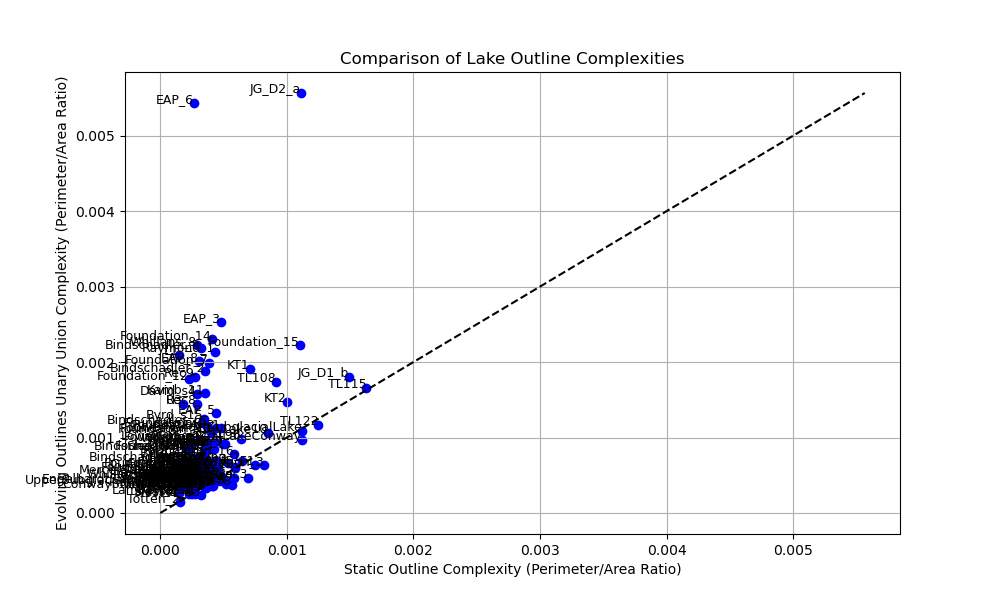

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(results_df['static_complexity'], results_df['evolving_complexity'], color='blue')

# Adding labels for each point
for i, row in results_df.iterrows():
    plt.text(row['static_complexity'], row['evolving_complexity'], row['lake_name'],
             fontsize=9, ha='right')

# Add a 1:1 line
max_complexity = max(results_df['static_complexity'].max(), results_df['evolving_complexity'].max())
plt.plot([0, max_complexity], [0, max_complexity], 'k--', label='1:1 Line')

plt.title('Comparison of Lake Outline Complexities')
plt.xlabel('Static Outline Complexity (Perimeter/Area Ratio)')
plt.ylabel('Evolving Outlines Unary Union Complexity (Perimeter/Area Ratio)')
plt.grid(True)
plt.show()

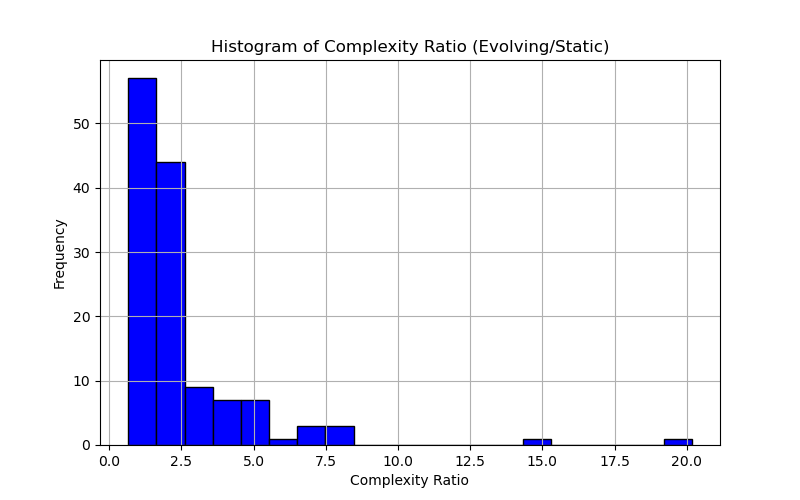

In [37]:
plt.figure(figsize=(8, 5))
plt.hist(results_df['complexity_ratio'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Complexity Ratio (Evolving/Static)')
plt.xlabel('Complexity Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [38]:
summary = results_df['complexity_ratio'].describe(percentiles=[.25, .5, .75])
five_number_summary = {
    'Minimum': summary['min'],
    '25th Percentile': summary['25%'],
    'Median': summary['50%'],
    '75th Percentile': summary['75%'],
    'Maximum': summary['max']
}
print(five_number_summary)

{'Minimum': 0.6573803850422693, '25th Percentile': 1.124860584905735, 'Median': 1.8009403395495445, '75th Percentile': 2.5516313595249325, 'Maximum': 20.174558948474143}


In [29]:
# What percentage of the previously identified lakes have a higher complexity 
count_above = (results_df['evolving_complexity'] > results_df['static_complexity']).sum()
np.round(count_above/len(results_df), 2)

0.85

## Wetted area

In [38]:
# Main loop to process each lake and store the results in a DataFrame
results = []

for idx, row in lakes_gdf.iterrows():
    result = find_max_darea_bias(lakes_gdf.loc[[idx]])
    if result:
        results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:

,lake_name,max_bias_area,evolving_union_static_diff
0,Bindschadler_2,-9.886725e+07,-9.751319e+07
1,Bindschadler_3,-1.324068e+08,-1.249029e+08
2,Bindschadler_4,-2.327672e+08,-1.908509e+08
3,Bindschadler_5,-1.787840e+08,-1.133862e+08
4,Bindschadler_6,-8.165519e+07,-5.250302e+07
...,...,...,...
128,WhillansSubglacialLake,2.709731e+07,2.753492e+07
129,Whillans_6,1.168100e+07,5.512309e+07
130,Whillans_7,5.641723e+07,6.534413e+07
131,Whillans_8,-1.567912e+08,-1.567912e+08


In [41]:
# What proportion of lakes have an individual time slice area that is larger that the static outline?
neg_count = results_df[results_df['max_bias_area'] < 0].shape[0]
np.round(neg_count/len(results_df), 2)

0.71

In [42]:
# What proportion of lakes have an evolving outlines unary union that is larger that the static outline?
neg_count = results_df[results_df['evolving_union_static_diff'] < 0].shape[0]
np.round(neg_count/len(results_df), 2)

0.59

In [43]:
# Combine all the evolving/static geometric calculation dataframes together to do 
# descriptive stats on each variable

# Replace 'your_folder_path' with the path to your folder containing GeoJSON files
directory = '/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./output/lake_outlines/compare_evolving_and_static_outlines'

# Initialize an empty list to store the DataFrames
dataframes = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    # Check if the file is a CSV and not the file to ignore
    if filename.endswith('.csv') and filename != 'all_previously_identified_lakes.csv':  # Ignore summation dataframe
        file_path = os.path.join(directory, filename)  # Get full path of the file
        df = pd.read_csv(file_path)  # Read the CSV file into a DataFrame
        df['lake_name'] = filename[:-4]  # Remove the .csv extension
        dataframes.append(df)  # Append the DataFrame to the list

# Concatenate all DataFrames in the list into one DataFrame
all_compare_evolving_and_static_outlines_df = pd.concat(dataframes, ignore_index=True)

In [48]:
# What proportion of time slice have an abs(static_outline_region_dh) > abs(evolving_outlines_region_dh) 
# when there is an evolving outline (otherwise rows without evolving outlines with zero for evolving_outlines_region_dh
# would distort proportion

# Filter the DataFrame to include only rows where 'evolving_outlines_region_dh (m)' > 0
filtered_df = all_compare_evolving_and_static_outlines_df[
    all_compare_evolving_and_static_outlines_df['evolving_outlines_region_dh (m)'] > 0]

# Calculate the absolute values for the filtered data
abs_static = abs(filtered_df['static_outline_dh (m)'])
abs_evolving = abs(filtered_df['evolving_outlines_region_dh (m)'])

# Create a boolean series where True indicates abs(static) > abs(evolving)
condition = abs_static > abs_evolving

# Calculate the proportion of True values in the condition
proportion = condition.mean()

print("Proportion of rows where abs(static_outline_dh (m)) > abs(evolving_outlines_region_dh (m)):", np.round(proportion, 2))

Proportion of rows where abs(static_outline_dh (m)) > abs(evolving_outlines_region_dh (m)): 0.78


In [15]:
# Find the five-number summary of the darea bias
variable = all_compare_evolving_and_static_outlines_df['bias_area (m^2)']

# Calculate the five-number summary
min_value = np.round(np.nanmin(variable)/1e6, 2)
q1 = np.round(np.nanpercentile(variable, 25)/1e6, 2)
median = np.round(np.nanmedian(variable)/1e6, 2)
q3 = np.round(np.nanpercentile(variable, 75)/1e6, 2)
max_value = np.round(np.nanmax(variable)/1e6, 2)

# Output the five-number summary
print(f"Minimum: {min_value}")
print(f"First quartile (Q1): {q1}")
print(f"Median: {median}")
print(f"Third quartile (Q3): {q3}")
print(f"Maximum: {max_value}")

Minimum: -1257.87
First quartile (Q1): -196.1
Median: -94.01
Third quartile (Q3): -33.15
Maximum: 4355.19


In [17]:
# Finding the index of the maximum value in the 'bias_area (m^2)' column
max_index = all_compare_evolving_and_static_outlines_df['bias_area (m^2)'].idxmax()
min_index = all_compare_evolving_and_static_outlines_df['bias_area (m^2)'].idxmax()

# Retrieving the row with the maximum value
print(all_compare_evolving_and_static_outlines_df.loc[max_index])
# print(all_compare_evolving_and_static_outlines_df.loc[min_index])

midcyc_datetime                      2020-08-16 18:45:00
evolving_outlines_darea (m^2)          5315108651.335535
evolving_outlines_dh (m)                        0.218534
evolving_region_dh (m)                           0.10225
evolving_outlines_dh_corr (m)                   0.116284
evolving_outlines_dvol_corr (m^3)       618064340.451527
static_outline_area                     959920029.875884
static_outline_dh (m)                           0.170722
static_outline_region_dh (m)                    0.159927
static_outline_dh_corr (m)                      0.010795
static_outline_dvol_corr (m^3)           10362019.363085
bias_area (m^2)                        4355188621.459651
bias_region_dh (m)                             -0.057677
bias_outlines_dh_corr (m)                        0.10549
bias_dvol_corr (m^3)                    607702321.088442
lake_name                                        David_1
Name: 1349, dtype: object


In [ ]:
# Replace 'your_folder_path' with the path to your folder containing GeoJSON files
folder_path = '/home/jovyan/1_outlines_candidates/Sauthoff-2024-J.Glaciol./output/lake_outlines/evolving_outlines/*.geojson'
files = glob.glob(folder_path)

levels = []

# Read each GeoJSON file and extract the first 'level' value
for file in files:
    gdf = gpd.read_file(file)
    # Make sure the GeoDataFrame is not empty and contains a 'level' column
    if not gdf.empty and 'level' in gdf.columns:
        first_level_value = gdf.iloc[0]['level']
        levels.append(first_level_value)

# Convert the list of levels to a numpy array for statistical analysis
levels_array = np.array(levels)

# Calculate the five-number summary
min_value = np.min(levels_array)
q1 = np.percentile(levels_array, 25)
median = np.median(levels_array)
q3 = np.percentile(levels_array, 75)
max_value = np.max(levels_array)

# Output the five-number summary
print(f"Minimum: {min_value}")
print(f"First quartile (Q1): {q1}")
print(f"Median: {median}")
print(f"Third quartile (Q3): {q3}")
print(f"Maximum: {max_value}")

# Fig. 2

/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


AttributeError: 'numpy.ndarray' object has no attribute 'add_collection'

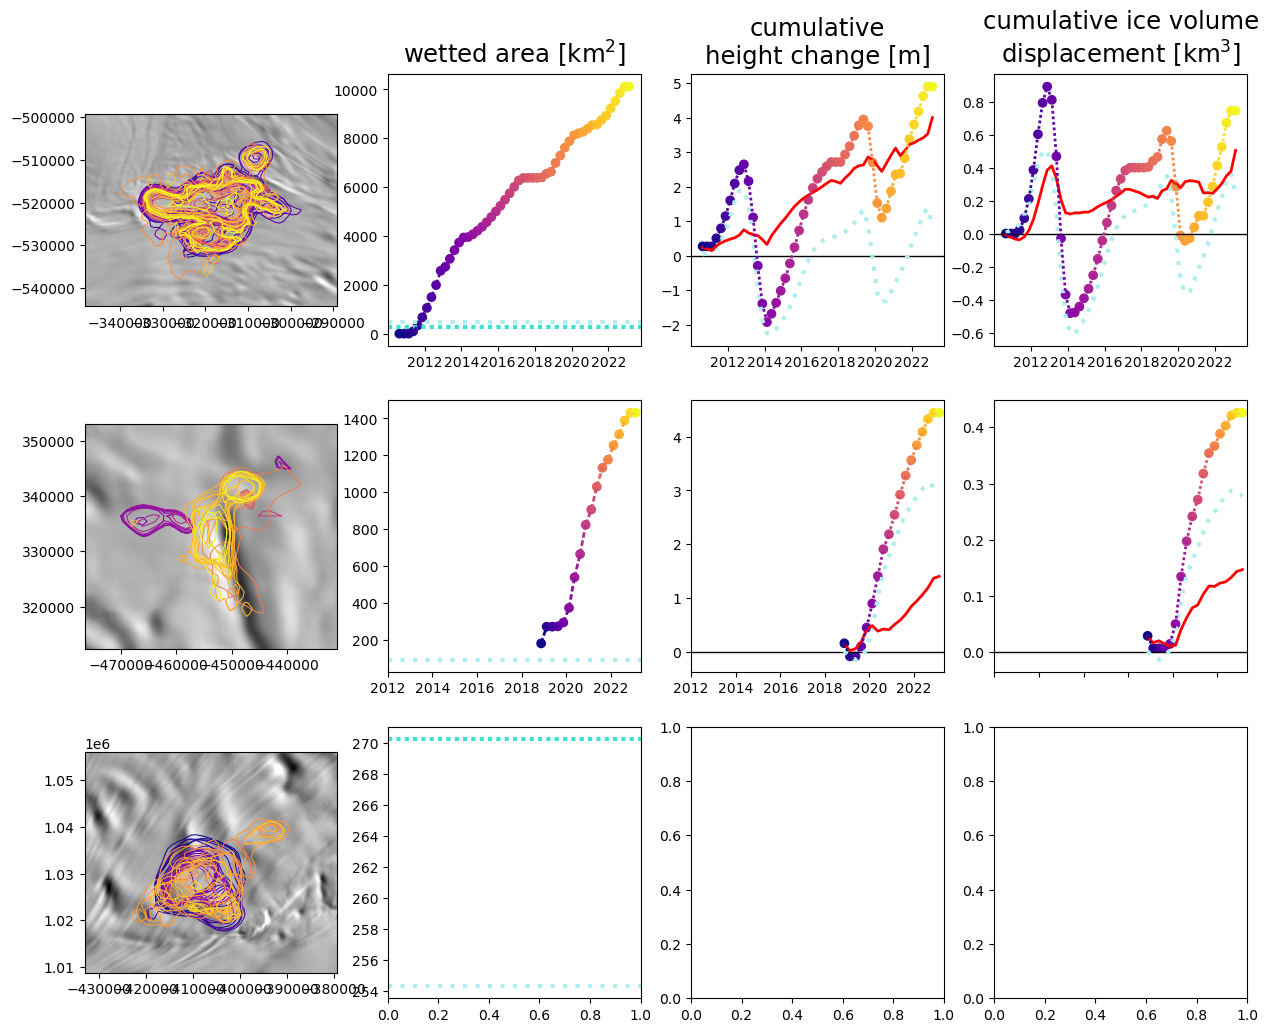

In [8]:
fig, ax = plt.subplots(3,4, figsize=(15,12))

# Define colors and linestyles that will be reused and create lines for legend
S09_color = 'paleturquoise'
SF18_color  = 'turquoise'
# lake_locations_postSF18_color = 'darkturquoise'
S09_linestyle=(0, (1, 2))
SF18_linestyle=(0, (1, 1))
S09_line = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=S09_linestyle, linewidth=2)
SF18_line = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=SF18_linestyle, linewidth=2)

# Panel A - evolving outlines ------------------------------------------------------
# Plot static and evolving outlines onto MOA surface imagery
# Open static outline(s) and evolving outlines and geometric calculation comparison geodataframes for plotting
S09_lake_gdf = S09_outlines[S09_outlines['Name'] == 'Whillans_4']
SF18_lake_gdf = SF18_outlines[SF18_outlines['name'] == 'ConwaySubglacialLake']
evolving_outlines_gdf = gpd.read_file(os.path.join(
    os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(SF18_lake_gdf['name'].values[0])))
geom_calcs_df = pd.read_csv(os.path.join(
    os.getcwd(), 'output/lake_outlines/compare_evolving_and_static_outlines/{}.csv'.format(SF18_lake_gdf['name'].values[0])))
# Convert of strings to datetime
geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])

# Combine static outline(s) with evolving outlines in unary union to plot all within bounds of plot
all_outlines_unary_union = unary_union([S09_lake_gdf.geometry.iloc[0], SF18_lake_gdf.geometry.iloc[0]] + list(evolving_outlines_gdf.geometry))
x_min, y_min, x_max, y_max = all_outlines_unary_union.bounds
buffer_frac = 0.2
x_buffer = abs(x_max-x_min)*buffer_frac
y_buffer = abs(y_max-y_min)*buffer_frac
mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
ax[0,0].imshow(moa_highres_da_subset[0,:,:], cmap="gray", clim=[14000, 17000], extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])

# Pick colormap and make continuous cmap discrete for evolving outlines
colormap = 'plasma'
continuous_cmap = matplotlib.colormaps[colormap]
discrete_cmap = colors.ListedColormap(continuous_cmap(np.linspace(0, 1, len(cyc_dates['midcyc_dates'])-1)))

# Norm to time variable
norm = plt.Normalize(mdates.date2num(cyc_dates['midcyc_dates'].iloc[0]), 
                     mdates.date2num(cyc_dates['midcyc_dates'].iloc[-1]))

# Use for loop to store each time slice as line segment to use in legend
# And plot each outline in the geopandas geodataframe and color by date
lines = []  # list of lines to be used for the legend
for idx, dt in enumerate(cyc_dates['midcyc_dates']):
    x = 1; y = 1
    line, = ax[0,0].plot(x, y, color=discrete_cmap(norm(mdates.date2num(cyc_dates['midcyc_dates'][idx]))), linewidth=3)
    lines.append(line)
    
    # Filter rows that match the current time slice
    evolving_outlines_gdf_dt_sub = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]

    # Plotting the subset if not empty
    if not evolving_outlines_gdf_dt_sub.empty:
        evolving_outlines_gdf_dt_sub.boundary.plot(ax=ax[0,0], color=discrete_cmap(norm(mdates.date2num(cyc_dates['midcyc_dates'][idx]))), linewidth=0.75)

# Set axes limit
ax[0,0].set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

# Panel - da/dt ---------------------------------------------
ax[0,1].axhline(np.divide(S09_lake_gdf['area (m^2)'], 1e6).values, color=S09_color, linestyle=S09_linestyle, linewidth=3)
ax[0,1].axhline(np.divide(SF18_lake_gdf['area (m^2)'], 1e6).values, color=SF18_color, linestyle=SF18_linestyle, linewidth=3)

# # Group by the 'date' column and sum the 'area' column
# grouped = evolving_outlines_gdf.groupby('midcyc_datetime')['area (m^2)'].sum().reset_index()
# grouped_data = grouped['area (m^2)'].tolist()
# grouped_data_dates = grouped['midcyc_datetime'].tolist()

# # Plot multi-colored line and scatter for data points
# x=[timestamp_to_fractional_year(date) for date in grouped_data_dates]
# y=np.divide(grouped_data, 1e6)
# # ax[0,1].plot(x,y)
# points = np.array([x, y]).T.reshape(-1, 1, 2)
# segments = np.concatenate([points[:-1], points[1:]], axis=1)
# # Create a continuous norm'ed 
# norm = plt.Normalize(np.min(x), np.max(x))  # Normalize to map data points to colors
# lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle=(0,(1,1)))
# # Set the values used for colormapping
# lc.set_array(x)
# lc.set_linewidth(2)
# line = ax[0,1].add_collection(lc)
# ax[0,1].scatter(x, y, c=x, cmap=colormap)

# Plot multi-colored line and scatter for data points
x=[timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']]
# x=geom_calcs_df['midcyc_datetime']
y=np.cumsum(np.divide(geom_calcs_df['evolving_outlines_darea (m^2)'], 1e6))
# x=[geom_calcs_df['midcyc_datetime'].tolist()]
# y=np.cumsum(geom_calcs_df['evolving_outlines_dh (m)'])
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x[0], x[-1])
# norm = plt.Normalize(timestamp_to_fractional_year(x.iloc[0]), timestamp_to_fractional_year(x.iloc[-1]))
lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle=(0,(2,1)))
# Set the values used for colormapping
lc.set_array(x)
lc.set_linewidth(2)
line = ax[0,1].add_collection(lc)
ax[0,1].scatter(x, y, c=x, cmap=colormap)

# Specify the years you want as ticks on the x-axis
time_series_even_years = [2012,2014,2016,2018,2020,2022]
# Change x ticks and labels to be even years in time series
ax[0,1].set_xticks(time_series_even_years)
ax[0,1].set_xticklabels([str(year) for year in time_series_even_years])

# Set title
ax[0,1].set_title('wetted area [km$^2$]', size=17.5, pad=8)

# Panel C - dh/dt -------------------------------------------------------
ax[0,2].axhline(0, color='k', linestyle='solid', linewidth=1)

# Plot static outline time series
ax[0,2].plot([timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']], np.cumsum(geom_calcs_df['static_outline_dh_corr (m)']), color=S09_color, linestyle=S09_linestyle, linewidth=3)
# ax[0,2].scatter([timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']], np.cumsum(geom_calcs_df['static_outline_dh_corr (m)']), facecolor=S09_color, linestyle=S09_linestyle, linewidth=3)

# Calc bias and plot
evolving_static_bias = [a_i - b_i for a_i, b_i in 
    zip(np.cumsum(geom_calcs_df['evolving_outlines_dh_corr (m)']), np.cumsum(geom_calcs_df['static_outline_dh_corr (m)']))]
ax[0,2].plot([timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']],
    evolving_static_bias, color='red', linestyle='solid', linewidth=2)

# Plot multi-colored line and scatter for data points
x=[timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']]
# x=geom_calcs_df['midcyc_datetime']
y=np.cumsum(geom_calcs_df['evolving_outlines_dh_corr (m)'])
# x=[geom_calcs_df['midcyc_datetime'].tolist()]
# y=np.cumsum(geom_calcs_df['evolving_outlines_dh (m)'])
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x[0], x[-1])
# norm = plt.Normalize(timestamp_to_fractional_year(x.iloc[0]), timestamp_to_fractional_year(x.iloc[-1]))
lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle=(0,(1,1)))
# Set the values used for colormapping
lc.set_array(x)
lc.set_linewidth(2)
line = ax[0,2].add_collection(lc)
ax[0,2].scatter(x, y, c=x, cmap=colormap)

# Change x ticks and labels to be even years in time series
ax[0,2].set_xticks(time_series_even_years)
ax[0,2].set_xticklabels([str(year) for year in time_series_even_years])

# Set title
ax[0,2].set_title('cumulative\nheight change [m]', size=17.5, pad=8)

# Panel D - dv/dt --------------------------------------------------
# Plot horizontal line at zero for reference
ax[0,3].axhline(0, color='k', linestyle='solid', linewidth=1)

# Plot static outline time series
ax[0,3].plot([timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']], 
    np.divide(np.cumsum(geom_calcs_df['static_outline_dvol_corr (m^3)']), 1e9), 
    color=S09_color, linestyle=S09_linestyle, linewidth=3)

# Calc bias and plot
S09_S24_bias = [a_i - b_i for a_i, b_i in 
    zip(np.cumsum(geom_calcs_df['evolving_outlines_dvol_corr (m^3)']), np.cumsum(geom_calcs_df['static_outline_dvol_corr (m^3)']))]
ax[0,3].plot([timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']],
    np.divide(S09_S24_bias, 1e9), color='red', linestyle='solid', linewidth=2)

# Plot multi-colored line and scatter for data points
x=[timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']]
y=np.divide(np.cumsum(geom_calcs_df['evolving_outlines_dvol_corr (m^3)']), 1e9)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x[0], x[-1])
lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle=(0,(1,1)))
# Set the values used for colormapping
lc.set_array(x)
lc.set_linewidth(2)
line = ax[0,3].add_collection(lc)
ax[0,3].scatter(x, y, c=x, cmap=colormap)

# Change x ticks and labels to be even years in time series
ax[0,3].set_xticks(time_series_even_years)
ax[0,3].set_xticklabels([str(year) for year in time_series_even_years])

# Set title
ax[0,3].set_title('cumulative ice volume\ndisplacement [km$^3$]', size=17.5, pad=8)

# 2nd row of plots -----------------------------------------------------------------------

# Plot static and evolving outlines onto MOA surface imagery
# Open static outline(s) and evolving outlines and geometric calculation comparison geodataframes for plotting
S09_lake_gdf = S09_outlines[S09_outlines['Name'] == 'Foundation_5']
SF18_lake_gdf = SF18_outlines[SF18_outlines['name'] == 'Foundation_5']
evolving_outlines_gdf = gpd.read_file(os.path.join(
    os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(SF18_lake_gdf['name'].values[0])))
geom_calcs_df = pd.read_csv(os.path.join(
    os.getcwd(), 'output/lake_outlines/compare_evolving_and_static_outlines/{}.csv'.format(SF18_lake_gdf['name'].values[0])))
# Convert of strings to datetime
geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])

# Combine static outline(s) with evolving outlines in unary union to plot all within bounds of plot
all_outlines_unary_union = unary_union([S09_lake_gdf.geometry.iloc[0]] + list(evolving_outlines_gdf.geometry))
                                       
x_min, y_min, x_max, y_max = all_outlines_unary_union.bounds
buffer_frac = 0.2
x_buffer = abs(x_max-x_min)*buffer_frac
y_buffer = abs(y_max-y_min)*buffer_frac
mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
ax[1,0].imshow(moa_highres_da_subset[0,:,:], cmap="gray", clim=[14000, 17000], extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])

# Norm to time variable
norm = plt.Normalize(mdates.date2num(cyc_dates['midcyc_dates'].iloc[0]), 
                     mdates.date2num(cyc_dates['midcyc_dates'].iloc[-1]))

# Use for loop to plot each outline in the geopandas geodataframe and color by date
for idx, dt in enumerate(cyc_dates['midcyc_dates']):
    # Filter rows that match the current time slice
    evolving_outlines_gdf_dt_sub = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]

    # Plotting the subset if not empty
    if not evolving_outlines_gdf_dt_sub.empty:
        evolving_outlines_gdf_dt_sub.boundary.plot(ax=ax[1,0], color=discrete_cmap(norm(mdates.date2num(cyc_dates['midcyc_dates'][idx]))), linewidth=0.75)

# Set axes limit
ax[1,0].set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

# Panel - da/dt ---------------------------------------------
ax[1,1].axhline(np.divide(S09_lake_gdf['area (m^2)'].sum(), 1e6), color=S09_color, linestyle=S09_linestyle, linewidth=3)
# ax[1,1].axhline(np.divide(SF18_lake_gdf['area (m^2)'], 1e6), color=SF18_color, linestyle=SF18_linestyle, linewidth=3)

# # Group by the 'date' column and sum the 'area' column
# grouped = evolving_outlines_gdf.groupby('midcyc_datetime')['area (m^2)'].sum().reset_index()
# grouped_data = grouped['area (m^2)'].tolist()
# grouped_data_dates = grouped['midcyc_datetime'].tolist()

# # Plot multi-colored line and scatter for data points
# x=[timestamp_to_fractional_year(date) for date in grouped_data_dates]
# y=np.divide(grouped_data, 1e6)
# # ax[1,1].plot(x,y)
# points = np.array([x, y]).T.reshape(-1, 1, 2)
# segments = np.concatenate([points[:-1], points[1:]], axis=1)
# # Create a continuous norm'ed 
# norm = plt.Normalize(np.min(x), np.max(x))  # Normalize to map data points to colors
# lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle=(0,(1,1)))
# # Set the values used for colormapping
# lc.set_array(x)
# lc.set_linewidth(2)
# line = ax[1,1].add_collection(lc)
# ax[1,1].scatter(x, y, c=x, cmap=colormap)

# Plot multi-colored line and scatter for data points
x=[timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']]
# x=geom_calcs_df['midcyc_datetime']
y=np.cumsum(np.divide(geom_calcs_df['evolving_outlines_darea (m^2)'], 1e6))
# x=[geom_calcs_df['midcyc_datetime'].tolist()]
# y=np.cumsum(geom_calcs_df['evolving_outlines_dh (m)'])
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x[0], x[-1])
# norm = plt.Normalize(timestamp_to_fractional_year(x.iloc[0]), timestamp_to_fractional_year(x.iloc[-1]))
lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle=(0,(2,1)))
# Set the values used for colormapping
lc.set_array(x)
lc.set_linewidth(2)
line = ax[1,1].add_collection(lc)
ax[1,1].scatter(x, y, c=x, cmap=colormap)

# Change x ticks and labels to be even years in time series
ax[1,1].set_xticks(time_series_even_years)
ax[1,1].set_xticklabels([str(year) for year in time_series_even_years])

# Panel C - dh/dt -------------------------------------------------------
ax[1,2].axhline(0, color='k', linestyle='solid', linewidth=1)

# Plot static outline time series
ax[1,2].plot([timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']], np.cumsum(geom_calcs_df['static_outline_dh_corr (m)']), color=S09_color, linestyle=S09_linestyle, linewidth=3)
# ax[1,2].scatter([timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']], np.cumsum(geom_calcs_df['static_outline_dh_corr (m)']), facecolor=S09_color, linestyle=S09_linestyle, linewidth=3)

# Calc bias and plot
S09_S24_bias = [a_i - b_i for a_i, b_i in 
    zip(np.cumsum(geom_calcs_df['evolving_outlines_dh_corr (m)']), np.cumsum(geom_calcs_df['static_outline_dh_corr (m)']))]
ax[1,2].plot([timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']],
    S09_S24_bias, color='red', linestyle='solid', linewidth=2)

# Plot multi-colored line and scatter for data points
x=[timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']]
# x=geom_calcs_df['midcyc_datetime']
y=np.cumsum(geom_calcs_df['evolving_outlines_dh_corr (m)'])
# x=[geom_calcs_df['midcyc_datetime'].tolist()]
# y=np.cumsum(geom_calcs_df['evolving_outlines_dh (m)'])
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x[0], x[-1])
# norm = plt.Normalize(timestamp_to_fractional_year(x.iloc[0]), timestamp_to_fractional_year(x.iloc[-1]))
lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle=(0,(1,1)))
# Set the values used for colormapping
lc.set_array(x)
lc.set_linewidth(2)
line = ax[1,2].add_collection(lc)
ax[1,2].scatter(x, y, c=x, cmap=colormap)

# Change x ticks and labels to be even years in time series
ax[1,2].set_xticks(time_series_even_years)
ax[1,2].set_xticklabels([str(year) for year in time_series_even_years])

# Panel D - dv/dt --------------------------------------------------
# Plot horizontal line at zero for reference
ax[1,3].axhline(0, color='k', linestyle='solid', linewidth=1)

# Plot static outline time series
ax[1,3].plot([timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']], 
    np.divide(np.cumsum(geom_calcs_df['static_outline_dvol_corr (m^3)']), 1e9), 
    color=S09_color, linestyle=S09_linestyle, linewidth=3)

# Calc bias and plot
S09_S24_bias = [a_i - b_i for a_i, b_i in 
    zip(np.cumsum(geom_calcs_df['evolving_outlines_dvol_corr (m^3)']), np.cumsum(geom_calcs_df['static_outline_dvol_corr (m^3)']))]
ax[1,3].plot([timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']],
    np.divide(S09_S24_bias, 1e9), color='red', linestyle='solid', linewidth=2)

# Plot multi-colored line and scatter for data points
x=[timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']]
y=np.divide(np.cumsum(geom_calcs_df['evolving_outlines_dvol_corr (m^3)']), 1e9)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x[0], x[-1])
lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle=(0,(1,1)))
# Set the values used for colormapping
lc.set_array(x)
lc.set_linewidth(2)
line = ax[1,3].add_collection(lc)
ax[1,3].scatter(x, y, c=x, cmap=colormap)

# Change x ticks and labels to be even years in time series
ax[1,3].set_xticks(time_series_even_years)
ax[1,3].set_xticklabels([])

# 3rd row of plots -----------------------------------------------------------------------

# Plot static and evolving outlines onto MOA surface imagery
# Open static outline(s) and evolving outlines and geometric calculation comparison geodataframes for plotting
S09_lake_gdf = S09_outlines[S09_outlines['Name'].isin(['Slessor_2', 'Slessor_3'])]
SF18_lake_gdf = SF18_outlines[SF18_outlines['name'] == 'Slessor_23']
evolving_outlines_gdf = gpd.read_file(os.path.join(
    os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(SF18_lake_gdf['name'].values[0])))
geom_calcs_df = pd.read_csv(os.path.join(
    os.getcwd(), 'output/lake_outlines/compare_evolving_and_static_outlines/{}.csv'.format(SF18_lake_gdf['name'].values[0])))
# Convert of strings to datetime
geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])

# Combine static outline(s) with evolving outlines in unary union to plot all within bounds of plot
all_outlines_unary_union = unary_union([S09_lake_gdf.geometry.iloc[0], SF18_lake_gdf.geometry.iloc[0]] + list(evolving_outlines_gdf.geometry))
x_min, y_min, x_max, y_max = all_outlines_unary_union.bounds
buffer_frac = 0.3
x_buffer = abs(x_max-x_min)*buffer_frac
y_buffer = abs(y_max-y_min)*buffer_frac
mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
ax[2,0].imshow(moa_highres_da_subset[0,:,:], cmap="gray", clim=[14000, 17000], extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])

# Norm to time variable
norm = plt.Normalize(mdates.date2num(cyc_dates['midcyc_dates'].iloc[0]), 
                     mdates.date2num(cyc_dates['midcyc_dates'].iloc[-1]))

# Use for loop to plot each outline in the geopandas geodataframe and color by date
for idx, dt in enumerate(cyc_dates['midcyc_dates']):
    # Filter rows that match the current time slice
    evolving_outlines_gdf_dt_sub = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]

    # Plotting the subset if not empty
    if not evolving_outlines_gdf_dt_sub.empty:
        evolving_outlines_gdf_dt_sub.boundary.plot(ax=ax[2,0], color=discrete_cmap(norm(mdates.date2num(cyc_dates['midcyc_dates'][idx]))), linewidth=0.75)

# Set axes limit
ax[2,0].set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

# Panel - da/dt ---------------------------------------------
ax[2,1].axhline(np.divide(S09_lake_gdf['area (m^2)'].sum(), 1e6), color=S09_color, linestyle=S09_linestyle, linewidth=3)
ax[2,1].axhline(np.divide(SF18_lake_gdf['area (m^2)'].sum(), 1e6), color=SF18_color, linestyle=SF18_linestyle, linewidth=3)

# # Group by the 'date' column and sum the 'area' column
# grouped = evolving_outlines_gdf.groupby('midcyc_datetime')['area (m^2)'].sum().reset_index()
# grouped_data = grouped['area (m^2)'].tolist()
# grouped_data_dates = grouped['midcyc_datetime'].tolist()

# # Plot multi-colored line and scatter for data points
# x=[timestamp_to_fractional_year(date) for date in grouped_data_dates]
# y=np.divide(grouped_data, 1e6)
# # ax[2,1].plot(x,y)
# points = np.array([x, y]).T.reshape(-1, 1, 2)
# segments = np.concatenate([points[:-1], points[1:]], axis=1)
# # Create a continuous norm'ed 
# norm = plt.Normalize(np.min(x), np.max(x))  # Normalize to map data points to colors
# lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle=(0,(2,1)))
# # Set the values used for colormapping
# lc.set_array(x)
# lc.set_linewidth(2)
# line = ax[2,1].add_collection(lc)
# ax[2,1].scatter(x, y, c=x, cmap=colormap)

# Plot multi-colored line and scatter for data points
x=[timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']]
# x=geom_calcs_df['midcyc_datetime']
y=np.cumsum(np.divide(geom_calcs_df['evolving_outlines_darea (m^2)'], 1e6))
# x=[geom_calcs_df['midcyc_datetime'].tolist()]
# y=np.cumsum(geom_calcs_df['evolving_outlines_dh (m)'])
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x[0], x[-1])
# norm = plt.Normalize(timestamp_to_fractional_year(x.iloc[0]), timestamp_to_fractional_year(x.iloc[-1]))
lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle=(0,(2,1)))
# Set the values used for colormapping
lc.set_array(x)
lc.set_linewidth(2)
line = ax[1].add_collection(lc)
ax[2,1].scatter(x, y, c=x, cmap=colormap)

# Change x ticks and labels to be even years in time series
ax[2,1].set_xticks(time_series_even_years)
ax[2,1].set_xticklabels([str(year) for year in time_series_even_years])

# Panel C - dh/dt -------------------------------------------------------
ax[2,2].axhline(0, color='k', linestyle='solid', linewidth=1)

# Plot static outline time series
ax[2,2].plot([timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']], np.cumsum(geom_calcs_df['static_outline_dh_corr (m)']), color=S09_color, linestyle=S09_linestyle, linewidth=3)
# ax[2,2].scatter([timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']], np.cumsum(geom_calcs_df['static_outline_dh_corr (m)']), facecolor=S09_color, linestyle=S09_linestyle, linewidth=3)

# Calc bias and plot
S09_S24_bias = [a_i - b_i for a_i, b_i in 
    zip(np.cumsum(geom_calcs_df['evolving_outlines_dh_corr (m)']), np.cumsum(geom_calcs_df['static_outline_dh_corr (m)']))]
ax[2,2].plot([timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']],
    S09_S24_bias, color='red', linestyle='solid', linewidth=2)

# Plot multi-colored line and scatter for data points
x=[timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']]
# x=geom_calcs_df['midcyc_datetime']
y=np.cumsum(geom_calcs_df['evolving_outlines_dh_corr (m)'])
# x=[geom_calcs_df['midcyc_datetime'].tolist()]
# y=np.cumsum(geom_calcs_df['evolving_outlines_dh (m)'])
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x[0], x[-1])
# norm = plt.Normalize(timestamp_to_fractional_year(x.iloc[0]), timestamp_to_fractional_year(x.iloc[-1]))
lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle=(0,(2,1)))
# Set the values used for colormapping
lc.set_array(x)
lc.set_linewidth(2)
line = ax[2,2].add_collection(lc)
ax[2,2].scatter(x, y, c=x, cmap=colormap)

# Change x ticks and labels to be even years in time series
ax[2,2].set_xticks(time_series_even_years)
ax[2,2].set_xticklabels([str(year) for year in time_series_even_years])

# Panel D - dv/dt --------------------------------------------------
# Plot horizontal line at zero for reference
ax[2,3].axhline(0, color='k', linestyle='solid', linewidth=1)

# Plot static outline time series
ax[2,3].plot([timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']], 
    np.divide(np.cumsum(geom_calcs_df['static_outline_dvol_corr (m^3)']), 1e9), 
    color=S09_color, linestyle=S09_linestyle, linewidth=3)

# Calc bias and plot
S09_S24_bias = [a_i - b_i for a_i, b_i in 
    zip(np.cumsum(geom_calcs_df['evolving_outlines_dvol_corr (m^3)']), np.cumsum(geom_calcs_df['static_outline_dvol_corr (m^3)']))]
ax[2,3].plot([timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']],
    np.divide(S09_S24_bias, 1e9), color='red', linestyle='solid', linewidth=2)

# Plot multi-colored line and scatter for data points
x=[timestamp_to_fractional_year(date) for date in geom_calcs_df['midcyc_datetime']]
y=np.divide(np.cumsum(geom_calcs_df['evolving_outlines_dvol_corr (m^3)']), 1e9)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x[0], x[-1])
lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle=(0,(2,1)))
# Set the values used for colormapping
lc.set_array(x)
lc.set_linewidth(2)
line = ax[2,3].add_collection(lc)
ax[2,3].scatter(x, y, c=x, cmap=colormap)

# Change x ticks and labels to be even years in time series
ax[2,3].set_xticks(time_series_even_years)
ax[2,3].set_xticklabels([str(year) for year in time_series_even_years])

# For all plots --------------------------------
# for i in ax: 
#     S09_outlines.boundary.plot(ax=i, edgecolor=S09_color, facecolor='none', linestyle=(0, (1, 2)), linewidth=3, alpha=1, zorder=0)
#     SiegfriedFricker2018_SF18outlines.boundary.plot(ax=i, edgecolor=SF18_color, facecolor='none', linestyle=(0, (1, 1)), linewidth=3, alpha=1, zorder=0)

# # Plot inset map
# axIns = ax.inset_axes([0.01, 0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
# axIns.set_aspect('equal')
# moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
# moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
# axIns.axis('off')

# # Plot black rectangle to indicate location
# rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
# axIns.add_artist(rect)

# Label axes
ax[2,0].set_xlabel('x [km]', size=16)
ax[1,0].set_ylabel('y [km]', size=16)

# Create colorbar 
m = plt.cm.ScalarMappable(cmap=discrete_cmap)
m.set_array(np.array([timestamp_to_fractional_year(date) for date in cyc_dates['midcyc_dates']]))
cax = inset_axes(ax[0,0],
                 width="100%",
                 height="3%",
                 loc=3,
                 bbox_to_anchor=[0,1.01,1,1],
                 bbox_transform=ax[0,0].transAxes,
                 borderpad=0,
                 )
cbar=fig.colorbar(m, ticks=np.array([2010,2012,2014,2016,2018,2020,2022]), 
             cax=cax, orientation='horizontal')#.set_label('evolving outline year', size=15)

# Move tick marks and labels to the top
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

# Set the label for the colorbar and adjust its size
cbar.set_label('evolving outline year', size=15, labelpad=10)

for subplot in [ax[0,0], ax[1,0], ax[2,0]]:
    # Plot previous static outline inventories
    S09_outlines.boundary.plot(ax=subplot, edgecolor=S09_color, facecolor='none', linestyle=S09_linestyle, linewidth=3, alpha=1, zorder=0)
    SF18_outlines_SF18only.boundary.plot(ax=subplot, edgecolor=SF18_color, facecolor='none', linestyle=SF18_linestyle, linewidth=3, alpha=1, zorder=0)
    
    # Change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    subplot.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    subplot.yaxis.set_major_formatter(ticks_y)
    
plt.show()